In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def signal(fs, freq, duration):
  t = np.arange(0, duration, 1/fs) # time vector
  x = np.exp(2j * np.pi * freq * t) # initialize signal
  x = x.reshape(1, -1) # reshapes to (1, samples)

  return x

In [3]:
# Nr = number of sensors
# d = distance between sensors
# theta_deg = angle of arrival

def steering_vector(Nr, d, theta_deg):
  theta = np.deg2rad(theta_deg)
  s = np.exp(2j * np.pi * np.arange(Nr) * d * np.sin(theta))

  return s

In [4]:
# complex signal

fs = 48000
freq = 1000 # Hz
duration = 0.1 # seconds
num_samps = 4800  # fs * duration

x = signal(fs, freq, duration)    # (1, samples)


# steering vector

Nr = 3
d = 0.5
theta_deg = 30

s = steering_vector(3, 0.5, 30)   # (Nr,)

# reshape for matrix multiplication
s = s.reshape(-1,1)   # (Nr, 1)


In [5]:
# Add random noise (optional)
noise = np.random.randn(Nr,num_samps) + 1j * np.random.rand(Nr, num_samps)

# Array of samples at each sensor Nr
X = s @ x   # (Nr, samples)
X = X + (0.1 * noise)
print(X.shape)

(3, 4800)


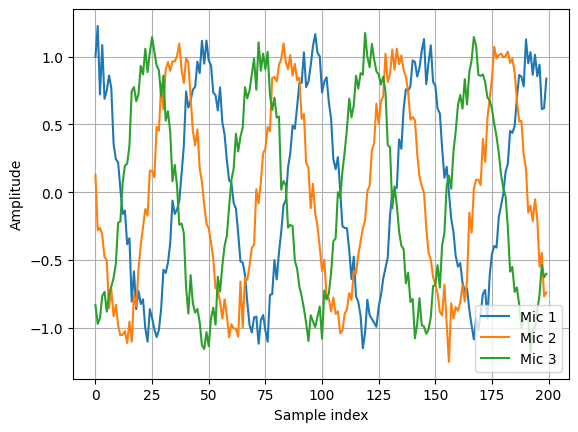

In [6]:
plt.plot(X[0,:200].real, label="Mic 1")
plt.plot(X[1,:200].real, label="Mic 2")
plt.plot(X[2,:200].real, label="Mic 3")
plt.legend()
plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

In [7]:
# Beamforming weights (Delay and Sum)
theta = np.deg2rad(theta_deg)
w = np.exp(2j * np.pi * d * np.arange(Nr) * np.sin(theta))
w = w.reshape(-1, 1)
print(w.shape)

X_weighted = w.conj().T @ X # example of applying the weights to the received signal (i.e., perform the beamforming)
print(X_weighted.shape) # (1, samples)

(3, 1)
(1, 4800)


(3,)
(3, 4800)
30.090090090090087


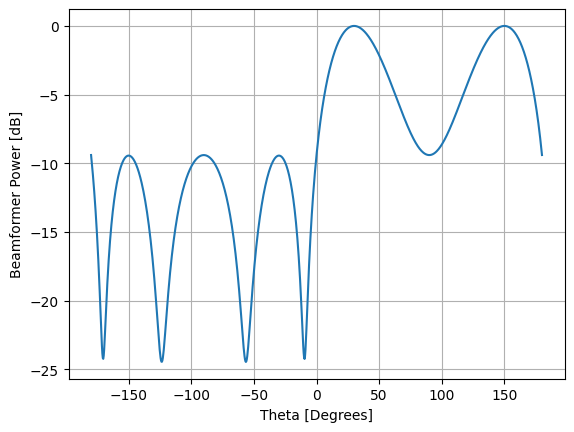

In [8]:
# Scanner for direction of arrival (DOA) (if not known) (NOTE: 180 degree ambiguity)

theta_scan = np.linspace(-1*np.pi, np.pi, 1000)
results = []
for theta_i in theta_scan:
  w = np.exp(2j * np.pi * d * np.arange(Nr) * np.sin(theta_i)) # Conventional, aka delay-and-sum, beamformer
  X_weighted = w.conj().T @ X # apply our weights. remember X is 3x10000
  results.append(10*np.log10(np.var(X_weighted))) # power in signal, in dB so its easier to see small and large lobes at the same time
results -= np.max(results) # normalize (optional)

print(w.shape)
print(X.shape)

# print angle that gave us the max value
print(theta_scan[np.argmax(results)] * 180 / np.pi) # 19.99999999999998

plt.plot(theta_scan*180/np.pi, results) # lets plot angle in degrees
plt.xlabel("Theta [Degrees]")
plt.ylabel("Beamformer Power [dB]")
plt.grid(True)
plt.show()

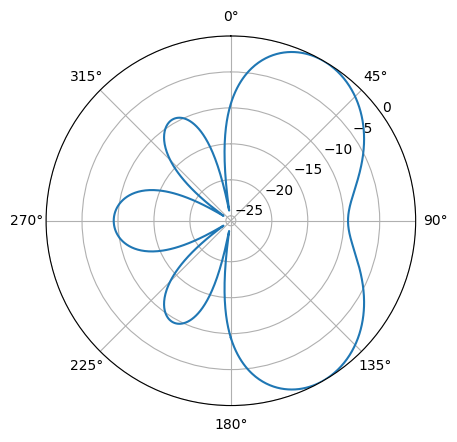

In [9]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta_scan, results) # MAKE SURE TO USE RADIAN FOR POLAR
ax.set_theta_zero_location('N') # make 0 degrees point up
ax.set_theta_direction(-1) # increase clockwise
ax.set_rlabel_position(55)  # Move grid labels away from other labels
plt.show()

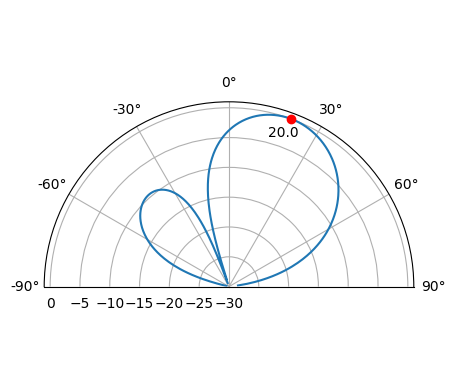

In [12]:
# Quiescent antenna pattern (array response) when steered towards a certain direction
# From: https://pysdr.org/content/doa.html#adaptive-beamforming

Nr = 3
d = 0.5
N_fft = 512
theta_degrees = 20 # there is no SOI, we arent processing samples, this is just the direction we want to point at
theta = theta_degrees / 180 * np.pi
w = np.exp(2j * np.pi * d * np.arange(Nr) * np.sin(theta)) # conventional beamformer
w_padded = np.concatenate((w, np.zeros(N_fft - Nr))) # zero pad to N_fft elements to get more resolution in the FFT
w_fft_dB = 10*np.log10(np.abs(np.fft.fftshift(np.fft.fft(w_padded)))**2) # magnitude of fft in dB
w_fft_dB -= np.max(w_fft_dB) # normalize to 0 dB at peak

# Map the FFT bins to angles in radians
theta_bins = np.arcsin(np.linspace(-1, 1, N_fft)) # in radians

# find max so we can add it to plot
theta_max = theta_bins[np.argmax(w_fft_dB)]

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta_bins, w_fft_dB) # MAKE SURE TO USE RADIAN FOR POLAR
ax.plot([theta_max], [np.max(w_fft_dB)],'ro')
ax.text(theta_max - 0.1, np.max(w_fft_dB) - 4, np.round(theta_max * 180 / np.pi))
ax.set_theta_zero_location('N') # make 0 degrees point up
ax.set_theta_direction(-1) # increase clockwise
ax.set_rlabel_position(55)  # Move grid labels away from other labels
ax.set_thetamin(-90) # only show top half
ax.set_thetamax(90)
ax.set_ylim([-30, 1]) # because there's no noise, only go down 30 dB
plt.show()